# Condition

In [1]:
import torch

if torch.cuda.is_available():
    device = "cuda:1"
else:
    device = "cpu"
print(device)

cuda:1


## Guidance

There are 2 types of guidance:
 - classifier-guided: use of another classifier and inject it into the diffusion model with a guidance scale factor.
 - classifier-free guidance: trys to push the generated noise to be pushed towards the conditioned noise in order to generate images under these conditions.

### Classifier- Guidance

In [10]:
from diffusers import DDPMPipeline, DDIMScheduler, UNet2DModel

device = "cuda:1"

# Load the pretrained pipeline
pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
pipeline_name = "chrisw225/ddpm-butterflies-128"
unet = UNet2DModel.from_pretrained(pipeline_name, subfolder="unet").to(device)

# Sample some images with a DDIM Scheduler over 40 steps
scheduler = DDIMScheduler.from_pretrained(pipeline_name, subfolder="scheduler")
scheduler.set_timesteps(num_inference_steps=40)



/home/Qingyi/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

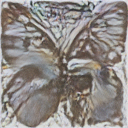

In [42]:
image_pipe = DDPMPipeline(unet, scheduler=scheduler)
images = image_pipeline(num_inference_steps=50)

images[0][0]

## classifier-free

In [109]:
import torch
import PIL.Image as Image
import torchvision.transforms as transforms
def mark_loss(images, target_img="/home/Qingyi/tmp/bee.jpg"):

    """"""
    img = Image.open(target_img).convert('L')

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])
    img = transform(img)
    # print(img.size())
    target = (
        img.to(images.device) * 2 - 1
    )  # Map target color to (-1, 1)


    target = target.unsqueeze(0)  # Get shape right to work with the images (b, c, h, w)


    error = torch.abs(
        images - target
    ).mean()  #

    return error

print(mark_loss(torch.rand((10,3,128,128))))

tensor(0.5595)


4it [00:00, 15.50it/s]

0 loss: 73.52860260009766


14it [00:00, 16.75it/s]

10 loss: 35.588600158691406


24it [00:01, 16.88it/s]

20 loss: 23.85053253173828


34it [00:02, 16.90it/s]

30 loss: 21.558185577392578


44it [00:02, 16.87it/s]

40 loss: 20.954437255859375


50it [00:02, 16.74it/s]


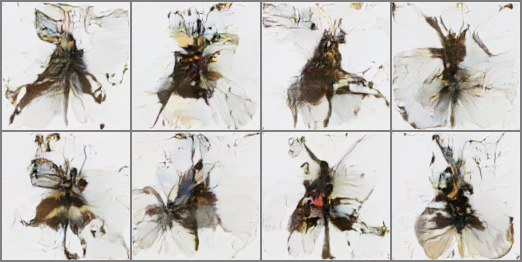

In [118]:
from tqdm import tqdm 
from torchvision.utils import make_grid
import numpy as np
import PIL.Image as Image

guidance_loss_scale = 70  # Explore changing this to 5, or 100

x = torch.randn(8, 3, 128, 128).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Prepare the model input
    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Set x.requires_grad to True
    x = x.detach().requires_grad_()

    # Get the predicted x0
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    # Calculate loss
    loss = mark_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample

# View the output
grid = make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

2it [00:00,  8.29it/s]

0 loss: 66.31269836425781


12it [00:01,  8.47it/s]

10 loss: 43.2418098449707


22it [00:02,  8.41it/s]

20 loss: 36.277732849121094


32it [00:03,  8.47it/s]

30 loss: 34.588382720947266


42it [00:04,  8.48it/s]

40 loss: 33.78929901123047


50it [00:05,  8.46it/s]


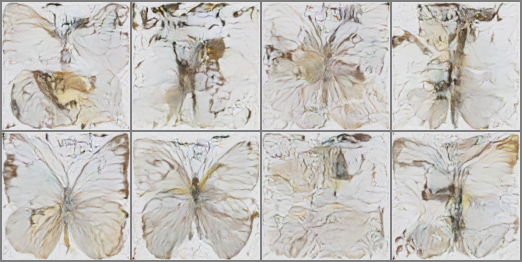

In [119]:
guidance_loss_scale = 70
x = torch.randn(8, 3, 128, 128).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Set requires_grad before the model forward pass
    x = x.detach().requires_grad_()
    model_input = scheduler.scale_model_input(x, t)

    # predict (with grad this time)
    noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Get the predicted x0:
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    # Calculate loss
    loss = mark_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample


grid = make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))